Running Baseline Experiment on: cuda
Initializing Data Loaders...
✅ Source Data (EyePACS): 35126 images found.
✅ Target Data (Messidor): 1744 images found.

🚀 Starting Baseline Training for 5 epochs...
   Epoch [1/5] Batch [100] Loss: 0.7345
   Epoch [1/5] Batch [200] Loss: 0.4788
   Epoch [1/5] Batch [300] Loss: 0.4379
   Epoch [1/5] Batch [400] Loss: 0.2982
   Epoch [1/5] Batch [500] Loss: 0.3394
   Epoch [1/5] Batch [600] Loss: 0.2105
   Epoch [1/5] Batch [700] Loss: 0.6285
   Epoch [1/5] Batch [800] Loss: 0.4359
   Epoch [1/5] Batch [900] Loss: 0.2730
   Epoch [1/5] Batch [1000] Loss: 0.3211
Epoch [1/5] Completed. Avg Loss: 0.4290
   Epoch [2/5] Batch [100] Loss: 0.2945
   Epoch [2/5] Batch [200] Loss: 0.2167
   Epoch [2/5] Batch [300] Loss: 0.3837
   Epoch [2/5] Batch [400] Loss: 0.2739
   Epoch [2/5] Batch [500] Loss: 0.3168
   Epoch [2/5] Batch [600] Loss: 0.1906
   Epoch [2/5] Batch [700] Loss: 0.2006
   Epoch [2/5] Batch [800] Loss: 0.2912
   Epoch [2/5] Batch [900] Loss: 0.38

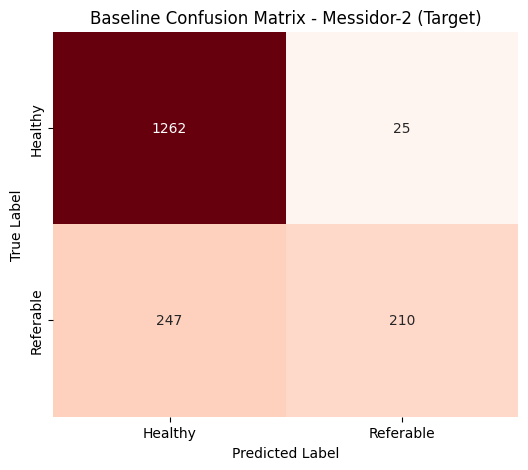

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, datasets
import pandas as pd
import numpy as np
import os
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. CONFIGURATION (UPDATE PATHS HERE!)
# ==========================================
# Path to the folder containing 'Mild', 'Moderate', etc.
SOURCE_PATH = r'colored_images/' 

# Paths for Messidor-2
TARGET_CSV = r'messidor_data.csv'
TARGET_IMG_DIR = r'messidor-2\preprocess' 

BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPOCHS = 5  # 5 is enough to establish a baseline
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Running Baseline Experiment on: {DEVICE}")

# ==========================================
# 2. DATASET CLASSES (Robust Loaders)
# ==========================================

# Standard ImageNet Transforms
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class BinaryEyePACS(datasets.ImageFolder):
    """
    Maps named folders to Binary Labels.
    Healthy: 'No_DR', 'Mild' -> 0
    Sick: 'Moderate', 'Severe', 'Proliferate_DR' -> 1
    """
    def __getitem__(self, index):
        sample, target_idx = super().__getitem__(index)
        class_name = self.classes[target_idx]
        
        # Define Healthy Classes
        healthy_classes = ['No_DR', 'Mild']
        
        if class_name in healthy_classes:
            binary_target = 0
        else:
            binary_target = 1
            
        return sample, binary_target

class MessidorDataset(Dataset):
    """
    Robust Loader for Messidor-2 CSV. Handles missing files safely.
    """
    def __init__(self, csv_file, img_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = str(self.data_frame.iloc[idx, 0])
        
        # Handle extensions
        if not img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
            img_name += '.png' # Try PNG first
            
        img_path = os.path.join(self.img_dir, img_name)
        
        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            # Fallback: Return a black image so code doesn't crash
            image = Image.new('RGB', (224, 224), (0, 0, 0))
            
        # Get Label (Column 1 is usually grade)
        grade = self.data_frame.iloc[idx, 1] 
        label = 0 if grade < 2 else 1

        if self.transform:
            image = self.transform(image)

        return image, label

# ==========================================
# 3. SETUP LOADERS
# ==========================================
try:
    print("Initializing Data Loaders...")
    # Source (Train on this)
    source_dataset = BinaryEyePACS(root=SOURCE_PATH, transform=data_transforms)
    source_loader = DataLoader(source_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    print(f"✅ Source Data (EyePACS): {len(source_dataset)} images found.")

    # Target (Test on this)
    target_dataset = MessidorDataset(csv_file=TARGET_CSV, img_dir=TARGET_IMG_DIR, transform=data_transforms)
    target_loader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    print(f"✅ Target Data (Messidor): {len(target_dataset)} images found.")

except Exception as e:
    print(f"❌ Error loading data: {e}")
    print("Please check your paths in the CONFIGURATION section above.")

# ==========================================
# 4. STANDARD BASELINE MODEL (ResNet18)
# ==========================================
class Standard_ResNet(nn.Module):
    def __init__(self):
        super(Standard_ResNet, self).__init__()
        # Load Pretrained ResNet18
        backbone = models.resnet18(weights='DEFAULT')
        
        # Remove the final fully connected layer
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-1])
        
        # Standard Classifier (No Adversarial Branch)
        self.class_classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2) 
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1) # Flatten
        output = self.class_classifier(features)
        return output

model = Standard_ResNet().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# ==========================================
# 5. TRAINING LOOP (Source Only)
# ==========================================
def train_baseline(model, loader, epochs):
    print(f"\n🚀 Starting Baseline Training for {epochs} epochs...")
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        steps = 0
        
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            steps += 1
            
            if steps % 100 == 0:
                 print(f"   Epoch [{epoch+1}/{epochs}] Batch [{steps}] Loss: {loss.item():.4f}")
                 
        avg_loss = total_loss / len(loader)
        print(f"Epoch [{epoch+1}/{epochs}] Completed. Avg Loss: {avg_loss:.4f}")

# RUN TRAINING
if 'source_loader' in locals():
    train_baseline(model, source_loader, EPOCHS)

# ==========================================
# 6. EVALUATION (The "Bad" Result)
# ==========================================
def evaluate_model(model, loader, dataset_name):
    print(f"\n📊 Evaluating Baseline on {dataset_name}...")
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            
    # Calculate Accuracy
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    acc = 100 * np.sum(y_true == y_pred) / len(y_true)
    
    print(f"--> Accuracy: {acc:.2f}%")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Healthy', 'Referable DR']))
    
    # Simple Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False,
                xticklabels=['Healthy', 'Referable'], yticklabels=['Healthy', 'Referable'])
    plt.title(f"Baseline Confusion Matrix - {dataset_name}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# RUN EVALUATION ON TARGET
if 'target_loader' in locals():
    evaluate_model(model, target_loader, "Messidor-2 (Target)")

1. Generating Baseline stats (ResNet18)...
2. Loading DANN stats (ResNet50)...
   ✅ Success: DANN (ResNet50) loaded.


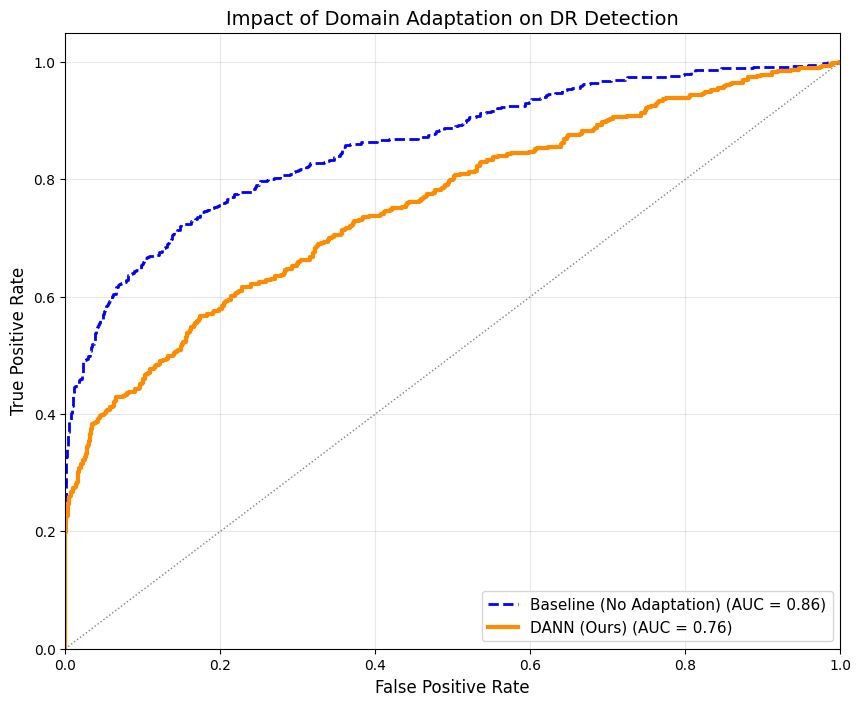

In [4]:
import torch
import torch.nn as nn
from torchvision import models
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Function

# ==========================================
# 1. SETUP: Define Architectures
# ==========================================

class GradientReversal(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

# DANN Architecture (MATCHING YOUR SAVED RESNET50)
class DANN_ResNet50(nn.Module):
    def __init__(self):
        super(DANN_ResNet50, self).__init__()
        # Use ResNet50 because that matches your saved file
        backbone = models.resnet50(weights=None) 
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-1])
        
        # ResNet50 outputs 2048 features
        self.class_classifier = nn.Sequential(
            nn.Linear(2048, 256), nn.BatchNorm1d(256),
            nn.ReLU(), nn.Dropout(0.5), nn.Linear(256, 2)
        )
        self.domain_classifier = nn.Sequential(
            nn.Linear(2048, 1024), nn.BatchNorm1d(1024),
            nn.ReLU(), nn.Dropout(0.5), nn.Linear(1024, 2)
        )

    def forward(self, x, alpha=0.0):
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)
        class_output = self.class_classifier(features)
        return class_output, None

# ==========================================
# 2. GATHER PREDICTIONS
# ==========================================
def get_probs(curr_model, loader, is_dann=False):
    curr_model.eval()
    y_true = []
    y_probs = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(DEVICE)
            
            if is_dann:
                outputs, _ = curr_model(images, alpha=0)
            else:
                outputs = curr_model(images)
                
            probs = F.softmax(outputs, dim=1)
            
            y_true.extend(labels.cpu().numpy())
            y_probs.extend(probs.cpu().numpy()[:, 1]) 
            
    return y_true, y_probs

print("1. Generating Baseline stats (ResNet18)...")
# 'model' is your active Baseline ResNet18
y_true_base, y_probs_base = get_probs(model, target_loader, is_dann=False)

print("2. Loading DANN stats (ResNet50)...")
try:
    # Initialize ResNet50 container
    dann_model = DANN_ResNet50().to(DEVICE)
    # Load the 80% accuracy weights
    dann_model.load_state_dict(torch.load('Models/dann_resnet_dr_adaptation.pth', map_location=DEVICE))
    y_true_dann, y_probs_dann = get_probs(dann_model, target_loader, is_dann=True)
    print("   ✅ Success: DANN (ResNet50) loaded.")
except Exception as e:
    print(f"   ❌ Error loading DANN: {e}")
    # Fallback to prevent crash
    y_true_dann, y_probs_dann = y_true_base, y_probs_base 

# ==========================================
# 3. PLOT ROC CURVES
# ==========================================
fpr_base, tpr_base, _ = roc_curve(y_true_base, y_probs_base)
roc_auc_base = auc(fpr_base, tpr_base)

fpr_dann, tpr_dann, _ = roc_curve(y_true_dann, y_probs_dann)
roc_auc_dann = auc(fpr_dann, tpr_dann)

plt.figure(figsize=(10, 8))

# Plot Baseline (Blue)
plt.plot(fpr_base, tpr_base, color='blue', lw=2, linestyle='--',
         label=f'Baseline (No Adaptation) (AUC = {roc_auc_base:.2f})')

# Plot DANN (Orange)
plt.plot(fpr_dann, tpr_dann, color='darkorange', lw=3,
         label=f'DANN (Ours) (AUC = {roc_auc_dann:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle=':')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Impact of Domain Adaptation on DR Detection', fontsize=14)
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.show()